<a href="https://colab.research.google.com/github/yvesgit/UnpackAI/blob/main/Yves_Multicat_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [2]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 7.6MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 1.2MB 13.6MB/s 
     |████████████████████████████████| 194kB 28.8MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
Mounted at /content/gdrive


In [3]:
#hide
from fastbook import *

Other Computer Vision Problems

##  Data acquisition

Note: untar_data did not work for me; it gave me "BadZipFile: File is not a zip file", although it unzipped fine on my laptop. 
So I uploaded the data to my Google drive. But for those who want to try to download it, here is the url:

'https://www.dropbox.com/s/0htmeoie69q650p/miml_dataset.zip'



In [4]:
!ls "/content/gdrive/MyDrive/Data/miml_dataset"

images	miml_labels_1.csv  miml_labels_2.csv


In [5]:
from fastai.vision.all import *
# miml_url = 'https://www.dropbox.com/s/0htmeoie69q650p/miml_dataset.zip'
# path = untar_data(miml_url)

In [18]:
df = pd.read_csv('/content/gdrive/MyDrive/Data/miml_dataset/miml_labels_2.csv')
df.head(12)

,Filenames,labels
0,1.jpg,desert
1,2.jpg,desert
2,3.jpg,desert
3,4.jpg,"desert,mountains"
4,5.jpg,desert
5,6.jpg,desert
6,7.jpg,"desert,mountains"
7,8.jpg,desert
8,9.jpg,desert
9,10.jpg,"desert,mountains"


In [7]:
df.shape

(2000, 2)

### Divide into training and validation subsets by randomly choosing 20% of the images

In [8]:
from random import sample, seed
random.seed(52)
valid_bool = [True]*2000
for i in sample(range(2000), k=400):
    valid_bool[i] = False

df['is_valid'] = valid_bool
df.head()

,Filenames,labels,is_valid
0,1.jpg,desert,True
1,2.jpg,desert,True
2,3.jpg,desert,False
3,4.jpg,"desert,mountains",True
4,5.jpg,desert,True


In [9]:
df['is_valid']

0        True
1        True
2       False
3        True
4        True
        ...  
1995     True
1996     True
1997     True
1998     True
1999     True
Name: is_valid, Length: 2000, dtype: bool

## Constructing a DataBlock

In [10]:
def get_x(r): return   Path.cwd()/'gdrive/MyDrive/Data/miml_dataset/images'/r['Filenames']
def get_y(r): return r['labels'].split(',')

In [11]:
def splitter(df):
    train = df.index[df['is_valid']].tolist()
    valid = df.index[~df['is_valid']].tolist()
    return train,valid

In [13]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

### Sanity Checks: 

In [24]:
len(dls.train),len(dls.valid)

(25, 7)

In [30]:
dls.train

In [29]:
dls.train.vocab

['desert', 'mountains', 'sea', 'sunset', 'trees']

### Display a sample of data:

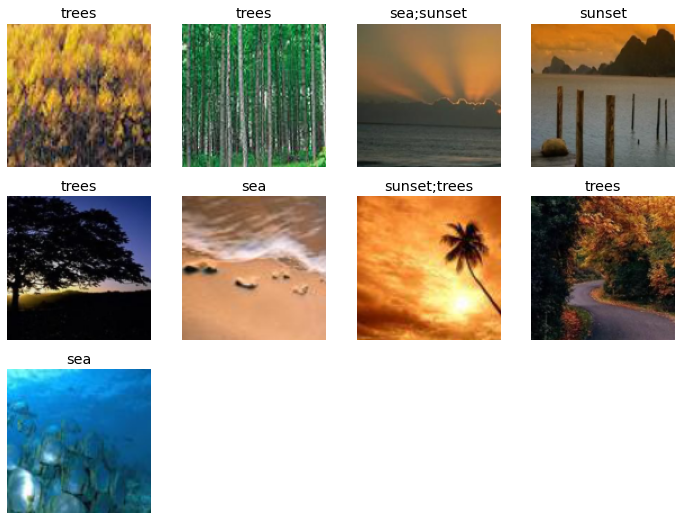

In [16]:
dls.show_batch(nrows=3, ncols=4)

## First Run

In [17]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.751682,0.496099,0.633500,07:23
1,0.601254,0.389610,0.765500,00:09
2,0.483507,0.280441,0.817500,00:09
3,0.391722,0.257808,0.844500,00:09


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.232626,0.189015,0.901000,00:09
1,0.193442,0.184610,0.917500,00:09
2,0.150036,0.156186,0.928000,00:09


### Threshhold

In [ ]:
preds,targs = learn.get_preds()

In [32]:
preds.shape, targs.shape

(torch.Size([400, 5]), (400, 5))

Note: I don't get why we want to not apply sigmoid at the end (sigmoid=False) but I'm following the course

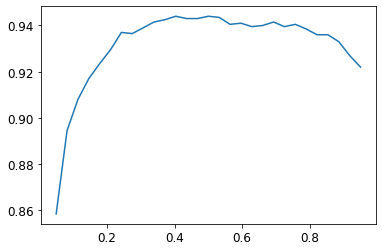

In [34]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

In [44]:
learn.metrics = partial(accuracy_multi, thresh=0.54)
learn.validate()

(#2) [0.15618585050106049,0.9440000057220459]

From playing around near the peak, I found 0.54 to be the best theshhold, yielding an accuracy of 94.4 %

<BR>


### Second Run
Find best learning rates and use discriminative LRs

In [45]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.54))

0.025118863582611083 0.02290867641568184


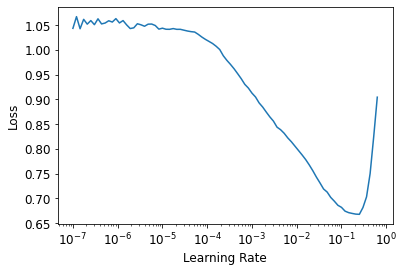

In [46]:
lr_min_pre_unfreeze,lr_steep_pre_unfreeze = learn.lr_find()
print(lr_min_pre_unfreeze,lr_steep_pre_unfreeze)

In [47]:
lr_my_choice = lr_steep_pre_unfreeze * (2/3)

In [48]:
learn.fit_one_cycle(4, lr_my_choice)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.543817,0.387540,0.884000,00:08
1,0.372202,0.230448,0.912500,00:08
2,0.299932,0.228312,0.918500,00:09
3,0.231158,0.169355,0.933500,00:08


Finding optimal threshhold of 0,52, yielding 93.4 % accuracy

<BR>





In [58]:
learn.unfreeze()

2.290867705596611e-05 1.9054607491852948e-06


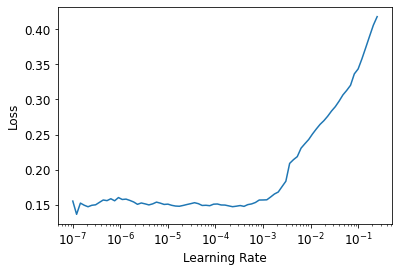

In [59]:
lr_min_post_unfreeze,lr_steep_post_unfreeze = learn.lr_find()
print(lr_min_post_unfreeze,lr_steep_post_unfreeze)

In [64]:
lr_min_post_unfreeze_adjusted = 10**(-5.6)
lr_max_post_unfreeze_adjusted = 10**(-3.6)

In [65]:
learn.fit_one_cycle(12, lr_max=slice(lr_min_post_unfreeze_adjusted,lr_max_post_unfreeze_adjusted))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.161567,0.158749,0.939000,00:09
1,0.153921,0.152699,0.942500,00:09
2,0.139824,0.160177,0.938500,00:09
3,0.130808,0.155623,0.941000,00:09
4,0.119414,0.160335,0.938000,00:09
5,0.106653,0.157543,0.941000,00:09
6,0.095533,0.165219,0.939500,00:09
7,0.085722,0.171053,0.940000,00:09
8,0.080260,0.173974,0.940000,00:09
9,0.074117,0.164579,0.940500,00:09


Let's play again with the threshhold

In [67]:
preds,targs = learn.get_preds()

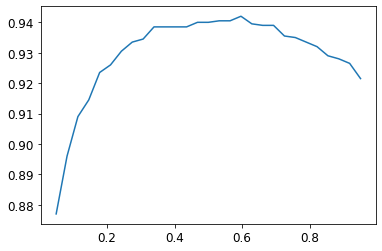

In [68]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

In [92]:
learn.metrics = partial(accuracy_multi, thresh=0.585)
learn.validate()

(#2) [0.16116510331630707,0.9424999952316284]

<BR>

Finding an optimal threshhold of 0.585, yielding 94.25 % accuracy

<BR>


## Questionnaire

1. How could multi-label classification improve the usability of the bear classifier?

The single label classification would be inaccurate in cases where there are no bears, or more than one type of bear. Mutli-level classification would address these cases as well.

1. How do we encode the dependent variable in a multi-label classification problem?

Typically, as a one hot embedding, adding as many columns as there are categories, and putting a 1 where the category is present, and 0 otherwise

1. How do you access the rows and columns of a DataFrame as if it was a matrix?

You can use .iloc[row_number, column_number] or .loc[row_name or number, column_name]

1. How do you get a column by name from a DataFrame?

df['column_name]

1. What is the difference between a `Dataset` and `DataLoader`?

A Dataset is an object containing just that - your data set, which can be sliced down to a single item. A Dataloader is an enumerator over a dataset, which return data items not individually, but in mini batches

1. What does a `Datasets` object normally contain?

Answered above

1. What does a `DataLoaders` object normally contain?

Answered above

1. What does `lambda` do in Python?

It allows you to create and execute a function all at once on the fly

1. What are the methods to customize how the independent and dependent variables are created with the data block API?

get_x and get_y

1. Why is softmax not an appropriate output activation function when using a one hot encoded target?

It is approipriate if the one hot encoded target has exactly one one in each row, i.e. if it is a single category classification problem. If it is a a multi category classification, the probabilities no longer excluded each other mutually, so they should not be expected to add up to 1.

1. Why is `nll_loss` not an appropriate loss function when using a one-hot-encoded target?

Because nll_loss applies to a single activation, not a multi-fold one


1. What is the difference between `nn.BCELoss` and `nn.BCEWithLogitsLoss`?

The latter combines cross entropy loss with sigmoid, whereas the latter does not include taking sigmoid

1. Why can't we use regular accuracy in a multi-label problem?

Regular accuracy compares the hghest activation with a single target, whereas we now must compare a set of activations exceeding a chosen theshhold with a set of targets.


1. When is it okay to tune a hyperparameter on the validation set?

When its accuracy curve is not erratic, thus ensuring that we do not get an outlier value for this hyperparameter


1. How is `y_range` implemented in fastai? (See if you can implement it yourself and test it without peeking!)

Using sigmoid, translating and dilating to a chosen interval

1. What is a regression problem? What loss function should you use for such a problem?
1. What do you need to do to make sure the fastai library applies the same data augmentation to your input images and your target point coordinates?